In [ ]:
!pip install -qU langchain-groq langchain langchain-community langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.4/131.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 8.5 MB/s eta 0:00:00


In [ ]:
import os
import json
from google.colab import userdata
from langchain_groq import ChatGroq
from langgraph.graph import END, StateGraph
from typing import TypedDict, List, Dict, Any

In [ ]:
os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')
llm = ChatGroq(temperature=0.7, model_name="openai/gpt-oss-120b")

In [ ]:
course_content_text = """
The Solar System consists of the Sun and the astronomical objects bound to it by gravity. Of the objects that orbit the Sun directly, the largest are the eight planets, with the remainder being smaller objects, such as the five dwarf planets and small Solar System bodies.

The four inner planets are Mercury, Venus, Earth, and Mars. They are called terrestrial planets because they have solid, rocky surfaces. The two largest planets, Jupiter and Saturn, are gas giants, being composed mainly of hydrogen and helium. The two outermost planets, Uranus and Neptune, are ice giants, being composed mostly of substances with relatively high melting points compared with hydrogen and helium, called volatiles, such as water, ammonia, and methane.

Mars is often called the 'Red Planet' because of its reddish appearance, which is caused by iron oxide (rust) on its surface. It has two small moons, Phobos and Deimos. Jupiter is the largest planet in the Solar System, more than twice as massive as all the other planets combined. It is famous for its Great Red Spot, a giant storm that has raged for at least 350 years.
"""


In [ ]:
class QuizGenerationState(TypedDict):
    content_text: str
    key_concepts: List[str]
    quiz_questions: List[Dict[str, Any]]
    formatted_quiz_json: str

# --- Node: Identify Key Concepts ---
def identify_key_concepts(state):
    print("---NODE: Identifying Key Concepts---")
    content_text = state["content_text"]

    prompt = f"""
    Based on the following course content, identify the top 3-5 most important, distinct, and testable key concepts or facts.
    Present these concepts as a simple list of strings.

    Course Content:
    "{content_text}"

    Example Format:
    ["Concept 1", "Concept 2", "Concept 3"]

    Key Concepts:
    """

    response = llm.invoke(prompt)
    concepts = [line.strip().replace('"', '').replace(',', '') for line in response.content.strip().replace('[', '').replace(']', '').split('\n') if line.strip()]

    print(f"Identified Concepts: {concepts}")
    return {"key_concepts": concepts}

# --- Node: Generate Quiz Questions ---
def generate_questions(state):
    print("---NODE: Generating Quiz Questions---")
    content_text = state["content_text"]
    concepts = state["key_concepts"]
    questions = []

    for concept in concepts:
        print(f"  - Generating question for concept: '{concept}'")
        prompt = f"""
        You are an expert quiz creator. Based on the provided course content, create one high-quality multiple-choice question specifically about the following concept: "{concept}".

        The question should have 4 options, with only one being correct. The incorrect options (distractors) should be plausible but clearly wrong based on the text.

        Course Content:
        "{content_text}"

        Format your response as a JSON object with the keys "question", "options" (a list of 4 strings), and "answer" (the correct option text).

        JSON Response:
        """

        response = llm.invoke(prompt)
        cleaned_response = response.content.strip().replace("```json", "").replace("```", "")
        try:
            question_json = json.loads(cleaned_response)
            questions.append(question_json)
        except json.JSONDecodeError:
            print(f"  - FAILED to decode JSON for concept: '{concept}'")
            continue

    print("Generated Questions (JSON objects):", questions)
    return {"quiz_questions": questions}

# --- Node: Format the Final JSON Output ---
def format_quiz_json(state):
    print("---NODE: Formatting Final JSON---")
    questions = state["quiz_questions"]
    formatted_json = json.dumps(questions, indent=2)
    return {"formatted_quiz_json": formatted_json}

In [ ]:
workflow = StateGraph(QuizGenerationState)

workflow.add_node("identify_key_concepts", identify_key_concepts)
workflow.add_node("generate_questions", generate_questions)
workflow.add_node("format_quiz_json", format_quiz_json)

workflow.set_entry_point("identify_key_concepts")
workflow.add_edge("identify_key_concepts", "generate_questions")
workflow.add_edge("generate_questions", "format_quiz_json")
workflow.add_edge("format_quiz_json", END)

app = workflow.compile()

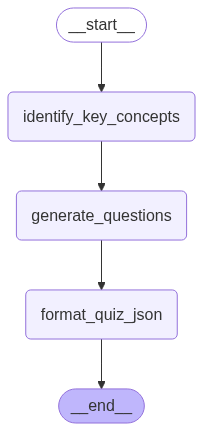

In [ ]:
app

In [ ]:
print("--- RUNNING QUIZ GENERATION AGENT ---")
inputs = {"content_text": course_content_text}
result = app.invoke(inputs)

print("\n\n================================\n")
print("--- FINAL GENERATED QUIZ (JSON) ---")
print(result['formatted_quiz_json'])

--- RUNNING QUIZ GENERATION AGENT ---
---NODE: Identifying Key Concepts---
Identified Concepts: ['The Solar System consists of the Sun and all objects gravitationally bound to it including eight planets dwarf planets and small bodies', 'Planet classification: inner terrestrial planets (Mercury Venus Earth Mars) have solid rocky surfaces; gas giants (Jupiter Saturn) are mainly hydrogen and helium; ice giants (Uranus Neptune) are rich in volatiles like water ammonia and methane', 'Mars appears red due to iron oxide on its surface and has two moons Phobos and Deimos', 'Jupiter is the most massive planet—over twice the combined mass of all other planets—and features the Great Red Spot a storm persisting for centuries']
---NODE: Generating Quiz Questions---
  - Generating question for concept: 'The Solar System consists of the Sun and all objects gravitationally bound to it including eight planets dwarf planets and small bodies'
  - Generating question for concept: 'Planet classification: i